In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from utilities import retrieve_data
import calendar

ERA_VERSION = 'ERA5'  # One day this will change to ERA6

# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'
KEY = '8f3ee43a-fa64-4eb9-a403-6567171bb625'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

# ====================
# These can be changed to get different data; leave them for now
# ====================
variable = "total_precipitation"
date_range = ["1991-01-01", "2020-12-31"]

# ====================
# Get the data. This will download a NetCDF file
# ====================
data_file = retrieve_data(KEY, variable, date_range, lat, lng)

{'variable': ['total_precipitation'], 'date': ['1991-01-01/2020-12-31'], 'location': {'longitude': 4.35, 'latitude': 50.86}, 'data_format': 'netcdf'}
total_precipitation_1991-01-01_2020-12-31_50.86_4.35.nc


2024-12-04 13:33:45,322 INFO [2024-07-18T00:00:00] Remember that you need to have an ECMWF account to use CDS-Beta. **Your existing CDS credentials will not work in CDS-Beta!**
2024-12-04 13:33:45,323 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2024-12-04 13:33:45,323 WARNING [2024-06-16T00:00:00] Check our [informative page](https://confluence.ecmwf.int/x/uINmFw) to best prepare yourself to use CDS-Beta.
2024-12-04 13:33:45,323 WARNING [2024-06-16T00:00:00] **BETA version** of the new CDS. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is very useful for us. **Please notice** that access to the system might suffer some disruptions due to evolving updates.
2024-12-04 13:33:45,478 INFO Request ID is b44603e7-11cd-4389-b1d9-a2

Retrieving data in to:  total_precipitation_1991-01-01_2020-12-31_50.86_4.35.nc


In [2]:
# Make a function to compute the monthly precipitation climatology
def precipMonthlyClimatology():
    """
    Calculate the monthly climatology of precipitation.

    This function reads precipitation data from a NetCDF file, converts the time coordinate
    to a pandas datetime index, and then resamples the data to calculate the monthly 
    climatology. The resulting climatology is returned in millimeters.

    Returns:
        pandas.DataFrame: A DataFrame containing the monthly climatology of precipitation 
        in millimeters, indexed by month.
    """


    data_tp_pt = xr.open_dataset(data_file).tp

    # Convert the time coordinate to a pandas datetime index
    time_index = pd.to_datetime(data_tp_pt.valid_time.values)

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame(data_tp_pt.values, index=time_index, columns=['tp'])

    df_monthly = df.resample('ME').sum()
    df_monthly['month'] = df_monthly.index.month
    monthly_climatology = df_monthly.groupby('month').mean() * 1000

    return monthly_climatology


# Call our function
clim = precipMonthlyClimatology()

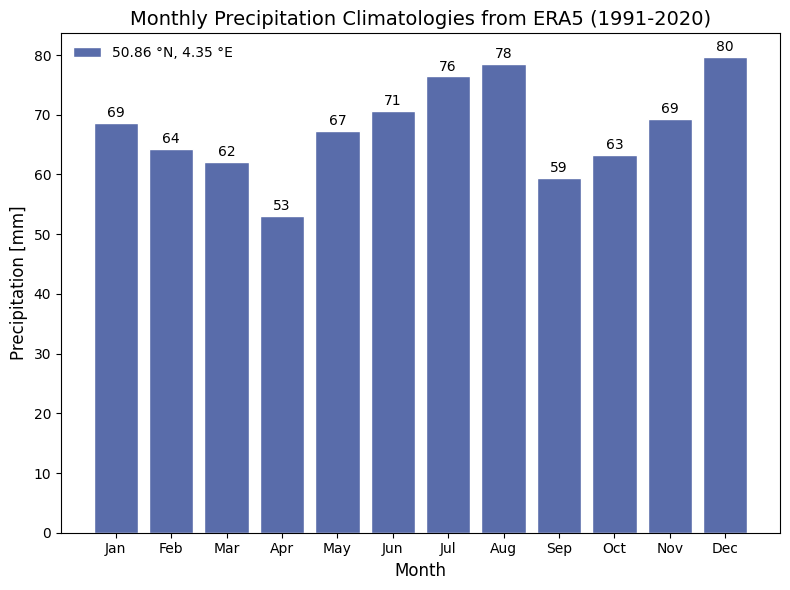

In [3]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

plt.figure(figsize=(8, 6))

# Plot the data as a bar chart
bars = plt.bar(
    clim.index,
    clim['tp'],
    width=0.8,
    color='#596CAA',
    edgecolor='white',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}'
)

# Add labels to the top of each bar
for bar in bars:
    height = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position
        height + 0.5,  # Y position (slightly above the bar)
        f'{height:.0f}',  # Label text
        ha='center',  # Center the text horizontally
        va='bottom',  # Align the text below the top of the bar
        fontsize=10,  # Font size of the label
        color='black'  # Text color
    )

# Add legend
plt.legend(framealpha=0)

# Customize x and y axis labels
plt.xlabel('Month', fontsize=12)
plt.ylabel('Precipitation [mm]', fontsize=12)

# Set x-ticks to month labels
plt.xticks(ticks=clim.index, labels=[calendar.month_abbr[i] for i in clim.index])

# Add title with custom font
plt.title(f'Monthly Precipitation Climatologies from {ERA_VERSION} ({date_range[0][:4]}-{date_range[1][:4]})', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()